In [27]:
import pandas as pd
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

In [28]:
# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
# event_acc = EventAccumulator('tensorboard_wes/bart-base_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-512_lr-1e-4')
# event_acc.Reload()
# # Show all tags in the log file
# print(event_acc.Tags())

In [29]:
model_name_to_Mparams_dict = {
    "flan-t5-small" : 77,
    "flan-t5-small-finetuned":77,
    "flan-t5-base" : 248,
    "flan-t5-base-finetuned":248,
    "flan-t5-large" : 783,
    "flan-t5-large-finetuned":783,
    "bart-base" : 140,
    "bart-large" : 400
}

In [30]:
import re

def extract_info(text):
    # Define the regex pattern to capture the desired components
    pattern = re.compile(r"""
        (?P<model_name>^[^_]+)             # Model name before the first underscore
        _                                 # Match a single underscore
        .*                                # Match any characters in between
        dpo-(?P<dpo_datasets>[^_]+)       # DPO datasets
        .*                                # Match any characters in between
        bs[-=](?P<batch_size>\d+)         # Batch size
        .*                                # Match any characters in between
        (?:ml|max-len)[-=](?P<max_len>\d+) # Max length
        .*                                # Match any characters in between
        lr[-=](?P<learning_rate>[0-9.e-]+)# Learning rate
    """, re.VERBOSE)

    match = pattern.match(text)
    if match:
        return match.groupdict()
    else:
        return None

In [31]:
import os
os.listdir("tensorboard")

['flan-t5-base_dpo-M1-orca-webgpt_bs=8_ml=256_lr=5e-5_r=16_a=64_lora',
 'bart-base_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-512_lr-1e-4',
 'flan-t5-large_dpo-M1-orca-webgpt_bs=4_ml=256_lr=1e-4_lora',
 'flan-t5-small_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-512_lr-5e-5',
 'flan-t5-small_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-512_lr-1e-4',
 'flan-t5-base_dpo-M1-orca-webgpt',
 'flan-t5-small_LoRA_dpo-orca-webgpt_bs-8_max-len-512_lr-1e-4',
 'flan-t5-base_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-256_lr-1e-4',
 'flan-t5-base_LoRA_dpo-M1-orca-webgpt_bs-4_max-len-512_lr-1e-4',
 'flan-t5-base_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-256_lr-5e-5',
 'flan-t5-base_LoRA_dpo-M1-orca-webgpt_bs-4_max-len-512_lr-5e-5',
 'flan-t5-base-finetuned_LoRA_dpo-M1-orca-webgpt_bs-4_max-len-512_lr-1e-4',
 'flan-t5-large-finetuned_dpo-M1-orca-webgpt_bs=4_ml=256_lr=1e-4_lora',
 'bart-large_LoRA_dpo-M1-orca-webgpt_bs-4_max-len-256_lr-1e-4',
 'flan-t5-small-finetuned_dpo-M1-orca-webgpt_bs=8_ml=512_lr=1e-4_lora']

In [32]:
train_losses = pd.DataFrame(columns = ['wall_time', 'step', 'value', 'model_name', 'dpo_datasets', 'batch_size', 'max_len', 'learning_rate', 'M_params', 'run_name'])

train_accuracies = pd.DataFrame(columns = ['wall_time', 'step', 'value', 'model_name', 'dpo_datasets', 'batch_size', 'max_len', 'learning_rate', 'M_params', 'run_name'])

eval_losses = pd.DataFrame(columns = ['epoch', 'wall_time', 'step', 'value', 'model_name', 'dpo_datasets', 'batch_size', 'max_len', 'learning_rate', 'M_params', 'run_name'])

eval_accuracies = pd.DataFrame(columns = ['epoch', 'wall_time', 'step', 'value', 'model_name', 'dpo_datasets', 'batch_size', 'max_len', 'learning_rate', 'M_params', 'run_name'])

for path_summary_folder in os.listdir('tensorboard'):
    print(f"{path_summary_folder=}")
    if path_summary_folder in ['flan-t5-base_dpo-M1-orca-webgpt_bs=8_ml=256_lr=5e-5_r=16_a=64_lora', 'flan-t5-base_dpo-M1-orca-webgpt', 'flan-t5-small_LoRA_dpo-orca-webgpt_bs-8_max-len-512_lr-1e-4']:
        continue
    event_acc = EventAccumulator('tensorboard/' + path_summary_folder)
    event_acc.Reload()
    run_info = extract_info(path_summary_folder)
    M_params = model_name_to_Mparams_dict[run_info['model_name']]
    # run_info['model_name'] = path_summary_folder
    
    # for tag in ['train/loss', 'eval/loss', 'train/rewards/accuracies', 'eval/rewards/accuracies']:
    run_train_loss = pd.DataFrame([scalar_event.__dict__ for scalar_event in  event_acc.Scalars('train/loss')])
    run_train_loss['model_name'] = run_info['model_name']
    run_train_loss['dpo_datasets'] = run_info['dpo_datasets']
    run_train_loss['batch_size'] = int(run_info['batch_size'])
    run_train_loss['max_len'] = int(run_info['max_len'])
    run_train_loss['learning_rate'] = float(run_info['learning_rate'])
    run_train_loss['M_params'] = M_params
    run_train_loss['run_name'] = path_summary_folder
    
    run_train_accuracies = pd.DataFrame([scalar_event.__dict__ for scalar_event in  event_acc.Scalars('train/rewards/accuracies')])
    run_train_accuracies['model_name'] = run_info['model_name']
    run_train_accuracies['dpo_datasets'] = run_info['dpo_datasets']
    run_train_accuracies['batch_size'] = int(run_info['batch_size'])
    run_train_accuracies['max_len'] = int(run_info['max_len'])
    run_train_accuracies['learning_rate'] = float(run_info['learning_rate'])
    run_train_accuracies['M_params'] = M_params
    run_train_accuracies['run_name'] = path_summary_folder
    
    run_eval_loss = pd.DataFrame([scalar_event.__dict__ for scalar_event in  event_acc.Scalars('eval/loss')])
    run_eval_loss['model_name'] = run_info['model_name']
    run_eval_loss['dpo_datasets'] = run_info['dpo_datasets']
    run_eval_loss['batch_size'] = int(run_info['batch_size'])
    run_eval_loss['max_len'] = int(run_info['max_len'])
    run_eval_loss['learning_rate'] = float(run_info['learning_rate'])
    run_eval_loss['M_params'] = M_params
    run_eval_loss['run_name'] = path_summary_folder
    run_eval_loss.reset_index(names='epoch', inplace=True)
    
    run_eval_accuracies = pd.DataFrame([scalar_event.__dict__ for scalar_event in  event_acc.Scalars('eval/rewards/accuracies')])
    run_eval_accuracies['model_name'] = run_info['model_name']
    run_eval_accuracies['dpo_datasets'] = run_info['dpo_datasets']
    run_eval_accuracies['batch_size'] = int(run_info['batch_size'])
    run_eval_accuracies['max_len'] = int(run_info['max_len'])
    run_eval_accuracies['learning_rate'] = float(run_info['learning_rate'])
    run_eval_accuracies['M_params'] = M_params
    run_eval_accuracies['run_name'] = path_summary_folder
    run_eval_accuracies.reset_index(names='epoch', inplace=True)
    
    train_losses = pd.concat([train_losses, run_train_loss], axis=0, ignore_index=True)
    train_accuracies = pd.concat([train_accuracies, run_train_accuracies], axis=0, ignore_index=True)
    eval_losses = pd.concat([eval_losses, run_eval_loss], axis=0, ignore_index=True)
    eval_accuracies = pd.concat([eval_accuracies, run_eval_accuracies], axis=0, ignore_index=True)
    
    
    

path_summary_folder='flan-t5-base_dpo-M1-orca-webgpt_bs=8_ml=256_lr=5e-5_r=16_a=64_lora'
path_summary_folder='bart-base_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-512_lr-1e-4'
path_summary_folder='flan-t5-large_dpo-M1-orca-webgpt_bs=4_ml=256_lr=1e-4_lora'
path_summary_folder='flan-t5-small_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-512_lr-5e-5'
path_summary_folder='flan-t5-small_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-512_lr-1e-4'


/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_87957/1355759816.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_losses = pd.concat([train_losses, run_train_loss], axis=0, ignore_index=True)
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_87957/1355759816.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_accuracies = pd.concat([train_accuracies, run_train_accuracies], axis=0, ignore_index=True)
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_8

path_summary_folder='flan-t5-base_dpo-M1-orca-webgpt'
path_summary_folder='flan-t5-small_LoRA_dpo-orca-webgpt_bs-8_max-len-512_lr-1e-4'
path_summary_folder='flan-t5-base_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-256_lr-1e-4'
path_summary_folder='flan-t5-base_LoRA_dpo-M1-orca-webgpt_bs-4_max-len-512_lr-1e-4'
path_summary_folder='flan-t5-base_LoRA_dpo-M1-orca-webgpt_bs-8_max-len-256_lr-5e-5'
path_summary_folder='flan-t5-base_LoRA_dpo-M1-orca-webgpt_bs-4_max-len-512_lr-5e-5'
path_summary_folder='flan-t5-base-finetuned_LoRA_dpo-M1-orca-webgpt_bs-4_max-len-512_lr-1e-4'
path_summary_folder='flan-t5-large-finetuned_dpo-M1-orca-webgpt_bs=4_ml=256_lr=1e-4_lora'
path_summary_folder='bart-large_LoRA_dpo-M1-orca-webgpt_bs-4_max-len-256_lr-1e-4'
path_summary_folder='flan-t5-small-finetuned_dpo-M1-orca-webgpt_bs=8_ml=512_lr=1e-4_lora'


In [33]:
train_accuracies['max_len | batch_size'] = train_accuracies['max_len'].astype(str) + ' | ' + train_accuracies['batch_size'].astype(str)

train_losses['max_len | batch_size'] = train_losses['max_len'].astype(str) + ' | ' + train_losses['batch_size'].astype(str)

eval_losses['max_len | batch_size'] = eval_losses['max_len'].astype(str) + ' | ' + eval_losses['batch_size'].astype(str)

eval_accuracies['max_len | batch_size'] = eval_accuracies['max_len'].astype(str) + ' | ' + eval_accuracies['batch_size'].astype(str)

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_87957/3376691393.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_losses[train_losses["model_name"] != 'bart-large'][train_losses["model_name"] != 'bart-base'],
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_87957/3376691393.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.lineplot(


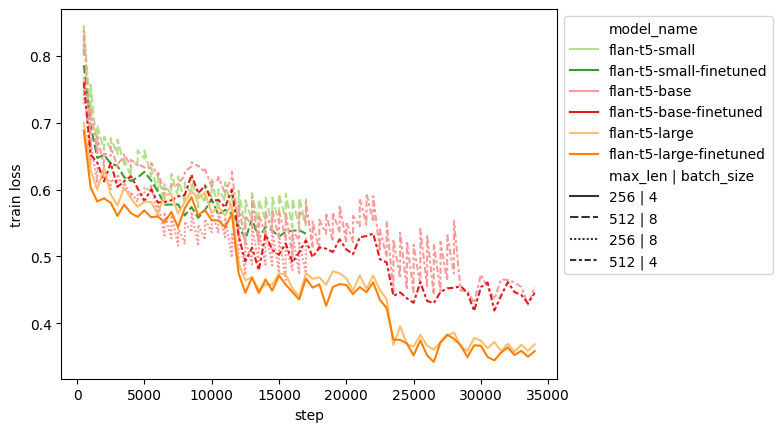

In [38]:
ax = sns.lineplot(
    train_losses[train_losses["model_name"] != 'bart-large'][train_losses["model_name"] != 'bart-base'],
    x = 'step',
    y = 'value',
    hue='model_name',
    # style='learning_rate',
    style = 'max_len | batch_size',
    estimator=None,
    hue_order = ['flan-t5-small', 'flan-t5-small-finetuned', 'flan-t5-base', 'flan-t5-base-finetuned', 'flan-t5-large', 'flan-t5-large-finetuned'],
    palette=sns.color_palette("Paired")[2:],
)
ax.set_ylabel('train loss')
ax.set_xlabel('step')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('plots/train_loss_step.png', dpi=400, bbox_inches='tight')

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_87957/4107003244.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eval_losses[eval_losses["model_name"] != 'bart-large'][eval_losses["model_name"] != 'bart-base'],
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_87957/4107003244.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.lineplot(


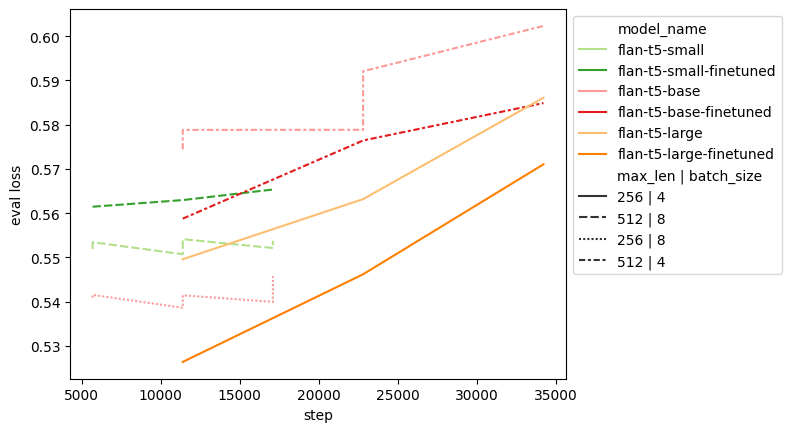

In [35]:
ax = sns.lineplot(
    eval_losses[eval_losses["model_name"] != 'bart-large'][eval_losses["model_name"] != 'bart-base'],
    x = 'step',
    y = 'value',
    hue='model_name',
    # style='learning_rate',
    style = 'max_len | batch_size',
    estimator=None,
    hue_order = ['flan-t5-small', 'flan-t5-small-finetuned', 'flan-t5-base', 'flan-t5-base-finetuned', 'flan-t5-large', 'flan-t5-large-finetuned'],
    palette=sns.color_palette("Paired")[2:],
    # palette = 'Paired',
)
ax.set_ylabel('eval loss')
ax.set_xlabel('step')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

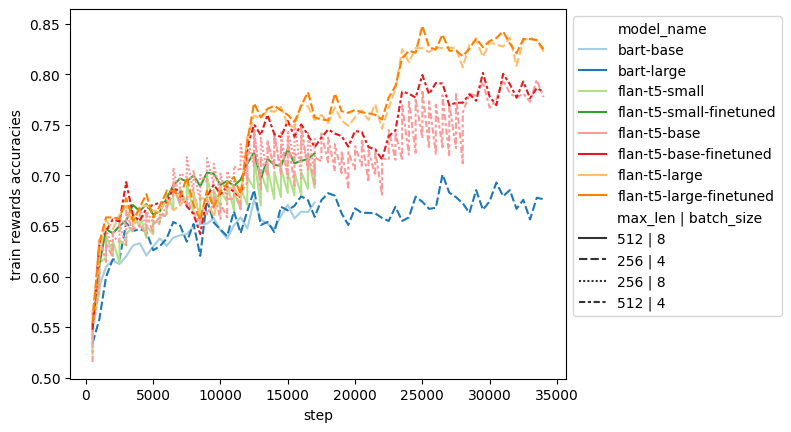

In [37]:
ax = sns.lineplot(
    train_accuracies,
    x = 'step',
    y = 'value',
    hue='model_name',
    # size='learning_rate',
    style = 'max_len | batch_size',
    estimator=None,
    hue_order = ['bart-base', 'bart-large', 'flan-t5-small', 'flan-t5-small-finetuned', 'flan-t5-base', 'flan-t5-base-finetuned', 'flan-t5-large', 'flan-t5-large-finetuned'],
    palette="Paired",
)

ax.set_ylabel('train rewards accuracies')
ax.set_xlabel('step')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('plots/train_rewards_acc_step.png', dpi=400, bbox_inches='tight')

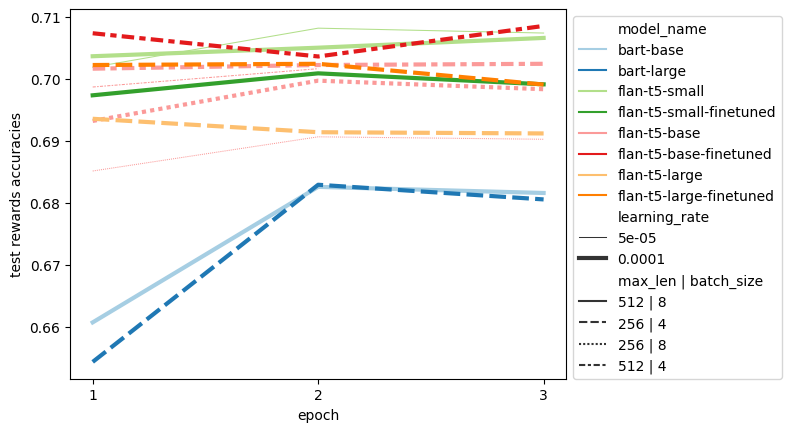

In [36]:
ax = sns.lineplot(
    eval_accuracies,
    # eval_accuracies,
    x = 'epoch',
    y = 'value',
    hue='model_name',
    size='learning_rate',
    style = 'max_len | batch_size',
    estimator=None,
    hue_order = ['bart-base', 'bart-large', 'flan-t5-small', 'flan-t5-small-finetuned', 'flan-t5-base', 'flan-t5-base-finetuned', 'flan-t5-large', 'flan-t5-large-finetuned'],
    palette="Paired",
)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([1, 2, 3])
ax.set_ylabel('test rewards accuracies')
ax.set_xlabel('epoch')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('plots/test_rewards_acc_epoch.png', dpi=400, bbox_inches='tight')

In [26]:
# ax = sns.barplot(
#     eval_accuracies[eval_accuracies['epoch'] == 2],
#     x = 'run_name',
#     y = 'value',
#     hue='model_name',
#     hue_order = ['bart-base', 'bart-large', 'flan-t5-small', 'flan-t5-small-finetuned', 'flan-t5-base', 'flan-t5-base-finetuned', 'flan-t5-large', 'flan-t5-large-finetuned'],
#     palette="Paired",
# )
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# ax.set_ylim(0.5)
# ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

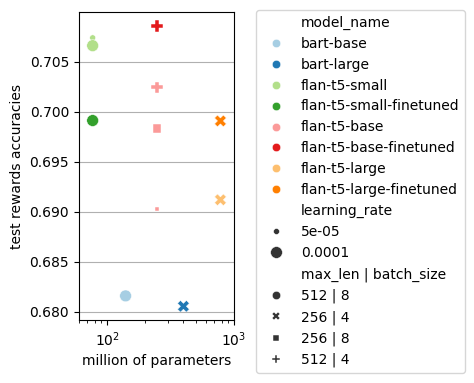

In [49]:
fig, ax = plt.subplots(figsize = (2, 4))
ax = sns.scatterplot(
    eval_accuracies[eval_accuracies['epoch'] == 2],
    style='max_len | batch_size',
    x='M_params',
    y='value',
    hue='model_name',
    size='learning_rate',
    hue_order = ['bart-base', 'bart-large', 'flan-t5-small', 'flan-t5-small-finetuned', 'flan-t5-base', 'flan-t5-base-finetuned', 'flan-t5-large', 'flan-t5-large-finetuned'],
    palette="Paired",
)
ax.set_xscale('log')
ax.set_xlim([60, 1000])
# ax.set_ylim([0.5, 1])
ax.set_ylabel('test rewards accuracies')
ax.set_xlabel('million of parameters')
plt.grid(axis='y', which='both')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1.03))
plt.savefig('plots/model_size_hp_test_acc_plot.png', dpi=400, bbox_inches='tight')

In [47]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [48]:
hue_order = ['bart-base', 'bart-large', 'flan-t5-small', 'flan-t5-small-finetuned', 'flan-t5-base', 'flan-t5-base-finetuned', 'flan-t5-large', 'flan-t5-large-finetuned']
{
    name:c for name, c in zip(['bart-base', 'bart-large', 'flan-t5-small', 'flan-t5-small-finetuned', 'flan-t5-base', 'flan-t5-base-finetuned', 'flan-t5-large', 'flan-t5-large-finetuned'], sns.color_palette("Paired"))
}   

{'bart-base': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'bart-large': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 'flan-t5-small': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'flan-t5-small-finetuned': (0.2, 0.6274509803921569, 0.17254901960784313),
 'flan-t5-base': (0.984313725490196, 0.6039215686274509, 0.6),
 'flan-t5-base-finetuned': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745),
 'flan-t5-large': (0.9921568627450981,
  0.7490196078431373,
  0.43529411764705883),
 'flan-t5-large-finetuned': (1.0, 0.4980392156862745, 0.0)}